In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

In [3]:
# Encoder and decoder use the DC-GAN architecture
# 28 x 28 x 1
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)   # None x 14 x 14 x 64
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)   # None x 7 x 7 x 128
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])]) # None x (7x7x128)
        fc1 = fc_lrelu(conv2, 1024)   
        return tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)

In [4]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output

In [5]:
# Build the computation graph for training
z_dim = 20
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_z = encoder(train_x, z_dim)
train_xr = decoder(train_z)

In [6]:
# Build the computation graph for generating samples
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

In [7]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):   # [batch_size, z_dim] [batch_size, z_dim]
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [8]:
# Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
true_samples = tf.random_normal(tf.stack([200, z_dim]))
loss_mmd = compute_mmd(true_samples, train_z)

In [9]:
loss_nll = tf.reduce_mean(tf.square(train_xr - train_x))
loss = loss_nll + loss_mmd
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss_mmd)

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [11]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = samples[:cnt*cnt]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
batch_size = 200
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Negative log likelihood is 0.231667, mmd loss is 0.003089


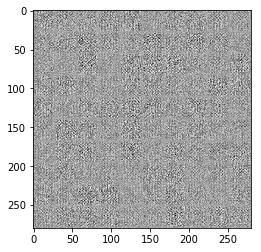

Negative log likelihood is 0.231578, mmd loss is 0.003067
Negative log likelihood is 0.231548, mmd loss is 0.003308
Negative log likelihood is 0.231381, mmd loss is 0.003003
Negative log likelihood is 0.231341, mmd loss is 0.003030
Negative log likelihood is 0.231109, mmd loss is 0.003120


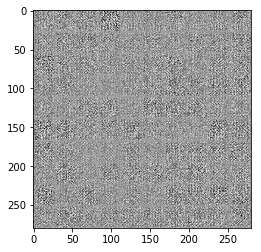

Negative log likelihood is 0.230883, mmd loss is 0.003129
Negative log likelihood is 0.231480, mmd loss is 0.003052
Negative log likelihood is 0.232043, mmd loss is 0.003231
Negative log likelihood is 0.231157, mmd loss is 0.003009
Negative log likelihood is 0.231387, mmd loss is 0.003259


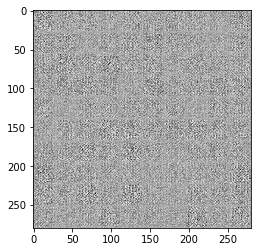

Negative log likelihood is 0.230921, mmd loss is 0.003043
Negative log likelihood is 0.231427, mmd loss is 0.003131
Negative log likelihood is 0.231758, mmd loss is 0.002974
Negative log likelihood is 0.231212, mmd loss is 0.002612
Negative log likelihood is 0.230913, mmd loss is 0.002956


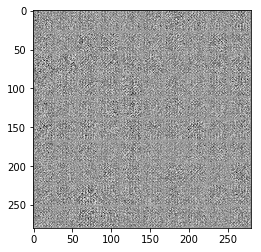

Negative log likelihood is 0.231175, mmd loss is 0.003000
Negative log likelihood is 0.231046, mmd loss is 0.002811
Negative log likelihood is 0.231261, mmd loss is 0.002918
Negative log likelihood is 0.231291, mmd loss is 0.003003
Negative log likelihood is 0.231189, mmd loss is 0.002959


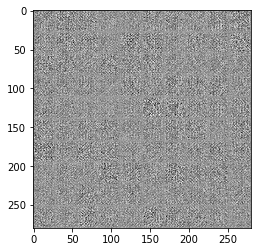

Negative log likelihood is 0.231109, mmd loss is 0.003308
Negative log likelihood is 0.231087, mmd loss is 0.002910
Negative log likelihood is 0.231293, mmd loss is 0.003025
Negative log likelihood is 0.231628, mmd loss is 0.002934
Negative log likelihood is 0.231370, mmd loss is 0.003216


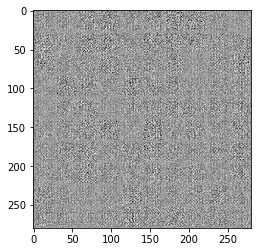

Negative log likelihood is 0.231473, mmd loss is 0.003216
Negative log likelihood is 0.231900, mmd loss is 0.002970
Negative log likelihood is 0.231494, mmd loss is 0.003241
Negative log likelihood is 0.231056, mmd loss is 0.003162
Negative log likelihood is 0.231298, mmd loss is 0.003135


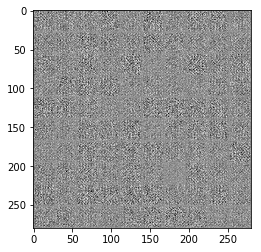

Negative log likelihood is 0.231170, mmd loss is 0.003129
Negative log likelihood is 0.231431, mmd loss is 0.002857
Negative log likelihood is 0.232045, mmd loss is 0.002978
Negative log likelihood is 0.231931, mmd loss is 0.002900
Negative log likelihood is 0.231146, mmd loss is 0.003069


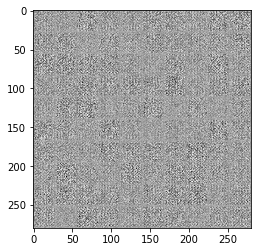

Negative log likelihood is 0.231784, mmd loss is 0.002999
Negative log likelihood is 0.231864, mmd loss is 0.003717
Negative log likelihood is 0.231324, mmd loss is 0.003151
Negative log likelihood is 0.230936, mmd loss is 0.003319
Negative log likelihood is 0.231748, mmd loss is 0.003310


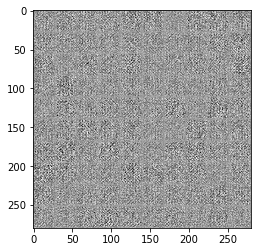

Negative log likelihood is 0.231790, mmd loss is 0.002913
Negative log likelihood is 0.231789, mmd loss is 0.003593
Negative log likelihood is 0.230690, mmd loss is 0.002764
Negative log likelihood is 0.230622, mmd loss is 0.002992
Negative log likelihood is 0.230905, mmd loss is 0.003083


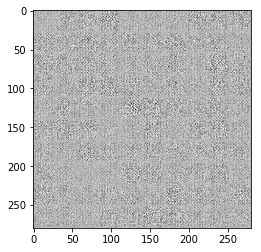

Negative log likelihood is 0.231111, mmd loss is 0.003121
Negative log likelihood is 0.231157, mmd loss is 0.002859
Negative log likelihood is 0.231075, mmd loss is 0.002996
Negative log likelihood is 0.231020, mmd loss is 0.002843
Negative log likelihood is 0.231357, mmd loss is 0.002878


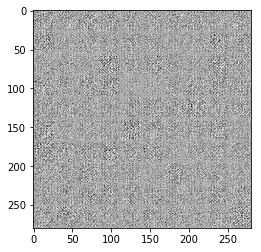

Negative log likelihood is 0.232083, mmd loss is 0.003392
Negative log likelihood is 0.231484, mmd loss is 0.003127
Negative log likelihood is 0.230497, mmd loss is 0.003007
Negative log likelihood is 0.231723, mmd loss is 0.003496
Negative log likelihood is 0.231085, mmd loss is 0.003131


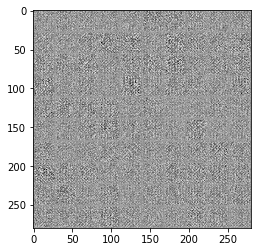

Negative log likelihood is 0.231197, mmd loss is 0.003122
Negative log likelihood is 0.231248, mmd loss is 0.002926
Negative log likelihood is 0.231372, mmd loss is 0.003644
Negative log likelihood is 0.230580, mmd loss is 0.003264
Negative log likelihood is 0.231578, mmd loss is 0.003354


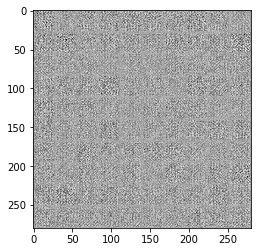

Negative log likelihood is 0.231878, mmd loss is 0.003117
Negative log likelihood is 0.231085, mmd loss is 0.003059
Negative log likelihood is 0.231526, mmd loss is 0.002913
Negative log likelihood is 0.231038, mmd loss is 0.003197
Negative log likelihood is 0.231083, mmd loss is 0.003147


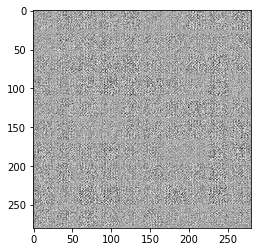

Negative log likelihood is 0.231335, mmd loss is 0.003006
Negative log likelihood is 0.231066, mmd loss is 0.002990
Negative log likelihood is 0.231754, mmd loss is 0.002830
Negative log likelihood is 0.231636, mmd loss is 0.003042
Negative log likelihood is 0.231075, mmd loss is 0.002965


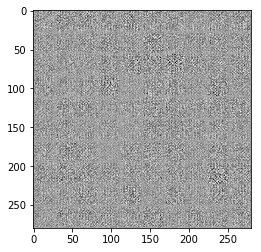

Negative log likelihood is 0.231453, mmd loss is 0.003023
Negative log likelihood is 0.231144, mmd loss is 0.002894
Negative log likelihood is 0.231600, mmd loss is 0.003061
Negative log likelihood is 0.230938, mmd loss is 0.003345
Negative log likelihood is 0.231359, mmd loss is 0.003038


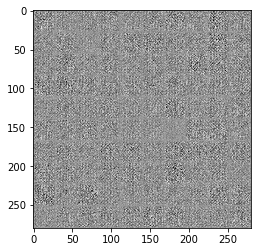

Negative log likelihood is 0.231169, mmd loss is 0.003030
Negative log likelihood is 0.231276, mmd loss is 0.003139
Negative log likelihood is 0.231089, mmd loss is 0.003072
Negative log likelihood is 0.231423, mmd loss is 0.003127
Negative log likelihood is 0.231834, mmd loss is 0.003051


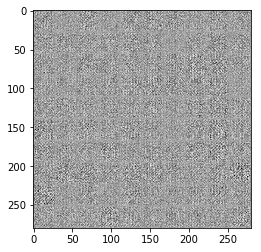

Negative log likelihood is 0.231556, mmd loss is 0.003042
Negative log likelihood is 0.231354, mmd loss is 0.003013
Negative log likelihood is 0.231021, mmd loss is 0.003444
Negative log likelihood is 0.231454, mmd loss is 0.003292
Negative log likelihood is 0.232003, mmd loss is 0.003142


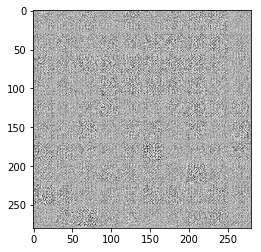

Negative log likelihood is 0.231340, mmd loss is 0.003249
Negative log likelihood is 0.231079, mmd loss is 0.003150
Negative log likelihood is 0.231012, mmd loss is 0.002782
Negative log likelihood is 0.231170, mmd loss is 0.003311
Negative log likelihood is 0.231210, mmd loss is 0.002878


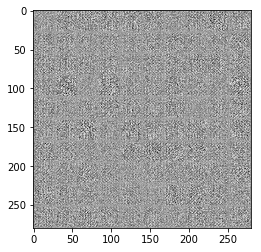

Negative log likelihood is 0.231438, mmd loss is 0.003013
Negative log likelihood is 0.231722, mmd loss is 0.003102
Negative log likelihood is 0.230999, mmd loss is 0.002970
Negative log likelihood is 0.231729, mmd loss is 0.003257
Negative log likelihood is 0.231248, mmd loss is 0.003411


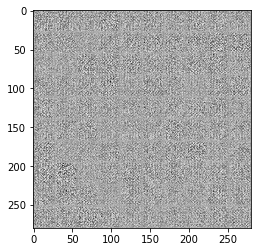

Negative log likelihood is 0.231506, mmd loss is 0.003290
Negative log likelihood is 0.231228, mmd loss is 0.003606
Negative log likelihood is 0.231656, mmd loss is 0.002872
Negative log likelihood is 0.230974, mmd loss is 0.002978


In [13]:
# Start training
for i in range(10000):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, mmd = sess.run([trainer, loss_nll, loss_mmd], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, mmd loss is %f" % (nll, mmd))
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

In [14]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    z_list, label_list = [], []
    test_batch_size = 500
    for i in range(20):
        batch_x, batch_y = mnist.test.next_batch(test_batch_size)
        batch_x = batch_x.reshape(-1, 28, 28, 1)
        z_list.append(sess.run(train_z, feed_dict={train_x: batch_x}))
        label_list.append(batch_y)
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()

In [15]:
from sklearn import svm
def semi_supervised_test(train_feature, train_label, test_feature, test_label):
    # Compute pair-wise distance
    x_range = np.sqrt(np.sum(np.square(np.max(train_feature, axis=0) - np.min(train_feature, axis=0))))
    gamma = 0.0001 / x_range
    optimal_gamma = gamma
    optimal_accuracy = 0
    while True:
        classifier = svm.SVC(decision_function_shape='ovr', gamma=gamma)
        classifier.fit(train_feature, train_label)

        pred = classifier.predict(test_feature)
        correct_count = np.sum([1 for j in range(test_feature.shape[0]) if test_label[j] == pred[j]])
        if correct_count > optimal_accuracy:
            optimal_accuracy = correct_count
            optimal_gamma = gamma
        # print("%f %d" % (gamma, correct_count))
        gamma *= 2.0
        if gamma > 100.0:
            break
    optimal_accuracy /= float(test_feature.shape[0])
    return optimal_accuracy, optimal_gamma

In [16]:
import time
def semi_supervised_eval():
    start_time = time.time()
    print("---------------------> Computing semi-supervised performance")
    train_features = []
    train_labels = []
    for j in range(100):
        bx, by = mnist.train.next_batch(100)
        bx = bx.reshape(-1, 28, 28, 1)
        train_features.append(sess.run(train_z, feed_dict={train_x: bx}))
        train_labels.append(by)
    train_feature = np.concatenate(train_features, axis=0)
    train_label = np.concatenate(train_labels, axis=0)

    test_features = []
    test_labels = []
    for j in range(100):
        bx, by = mnist.test.next_batch(100)
        bx = bx.reshape(-1, 28, 28, 1)
        test_features.append(sess.run(train_z, feed_dict={train_x: bx}))
        test_labels.append(by)
    test_feature = np.concatenate(test_features, axis=0)
    test_label = np.concatenate(test_labels)

    accuracy_list = []
    for j in range(10):
        random_ind = np.random.choice(train_feature.shape[0], size=1000, replace=False)
        accuracy, gamma = semi_supervised_test(train_feature[random_ind, :], train_label[random_ind], test_feature, test_label)
        accuracy_list.append(accuracy)
        print("Processed %d-th batch for 1000 label semi-supervised learning, time elapsed %f" % (j, time.time() - start_time))
    accuracy1000 = np.mean(accuracy_list)
    print("Semi-supervised 1000 performance is %f" % accuracy1000)

    accuracy_list = []
    for j in range(10):
        random_ind = np.random.choice(train_feature.shape[0], size=100, replace=False)
        accuracy, gamma = semi_supervised_test(train_feature[random_ind, :], train_label[random_ind], test_feature, test_label)
        accuracy_list.append(accuracy)
        if j % 10 == 0:
            print("Processed %d-th batch for 100 label semi-supervised learning, time elapsed %f" % (j, time.time() - start_time))
    accuracy100 = np.mean(accuracy_list)
    print("Semi-supervised 100 performance is %f" % accuracy100)
    return accuracy1000, accuracy100

In [17]:
semi_supervised_eval()

---------------------> Computing semi-supervised performance
Processed 0-th batch for 1000 label semi-supervised learning, time elapsed 8.786214
Processed 1-th batch for 1000 label semi-supervised learning, time elapsed 17.170530
Processed 2-th batch for 1000 label semi-supervised learning, time elapsed 25.582466
Processed 3-th batch for 1000 label semi-supervised learning, time elapsed 33.885446
Processed 4-th batch for 1000 label semi-supervised learning, time elapsed 42.101691
Processed 5-th batch for 1000 label semi-supervised learning, time elapsed 50.323420
Processed 6-th batch for 1000 label semi-supervised learning, time elapsed 58.541147
Processed 7-th batch for 1000 label semi-supervised learning, time elapsed 66.723438
Processed 8-th batch for 1000 label semi-supervised learning, time elapsed 74.927500
Processed 9-th batch for 1000 label semi-supervised learning, time elapsed 83.211780
Semi-supervised 1000 performance is 0.214360
Processed 0-th batch for 100 label semi-super

(0.21435999999999997, 0.11756)